In [1]:
import pandas as pd
import time
import numpy as np
import struct
import matplotlib.pyplot as plt
from cr_data_inspection_functions import *
from lwa_antpos import mapping
from scipy.optimize import curve_fit
import math

Read antpos from xlsx file in repo


In this first version I make cuts on events based on the number of antennas with a strong detection and based on whether the rms soon after the event is larger than in the beginning of the buffer.  Then, I make some plots for the events that pass the cuts.

TO DO: I should change how the plot_fit function does the color scaling. Something is going wrong on some of the plots.

In [2]:
#load data
#fname = '/data1/cosmic-ray-data/2023May3/overnight1683180610.6110308.dat'
print('Start time ',time.time())
fname='/data0/cosmic-ray-data/2023May3/overnight1683180640.2699194.dat'
records = parsefile(fname, end_ind = 704*1000) #note the first file actually only has 28 events
#make a list of events
events=distinguishevents(records,200)
complete_events_count=0
incomplete_events_count=0
total=len(events)
for e in events:
    if len(e)==704:
        complete_events_count+=1
    else:
        incomplete_events_count+=1
print("Out of ",total," events, there are ",complete_events_count," have exactly 704 records assigned and ", incomplete_events_count, ' events have the wrong number of records.')
print('End time ',time.time())


Start time  1685507958.5415952
Out of  1002  events, there are  987  have exactly 704 records assigned and  15  events have the wrong number of records.
End time  1685509100.9135818


In [3]:
## load array map
array_map=pd.read_csv('array-map-5-22-2023.csv')
xdict={}
ydict={}
zdict={}
for i,n in enumerate(array_map['antname']):
    xdict[n]=array_map['x'][i]
    ydict[n]=array_map['y'][i]
    zdict[n]=array_map['elevation'][i]
arraymapdictionaries=[xdict,ydict,zdict]

In [5]:
#take only the events that have 704 antennas
complete_events=[event for event in events if len(event)==704]
print(len(events))
print(len(complete_events))

1002
987


In [14]:
#parameters for antenna-based cuts
maximum_ok_rms=45
minimum_ok_rms=25
minsnr=6

print('Start time ',time.time())

#arrays to store summary info for each event
rms_ratioA=np.zeros(len(complete_events))
rms_ratioB=np.zeros(len(complete_events))

n_strong_detectionsA=np.zeros(len(complete_events))
n_strong_detectionsB=np.zeros(len(complete_events))

n_veto_detections=np.zeros(len(complete_events))
core_vs_far_ratioB=np.zeros(len(complete_events))
core_vs_far_ratioA=np.zeros(len(complete_events))

#go through each event
for i,event_indices in enumerate(complete_events):  
    event=[records[i] for i in event_indices]
    mergedrecords=mergepolarizations(event,arraymapdictionaries)

    
    xcoords=np.asarray([record['x'] for record in mergedrecords])
    ycoords=np.asarray([record['y'] for record in mergedrecords])
    zcoords=np.asarray([record['z'] for record in mergedrecords])
    
    #get rms and peak to rms ratio
    rmsA=np.asarray([record['rmsA'] for record in mergedrecords])
    peakA=np.asarray([record['peakA'] for record in mergedrecords])
    rmsB=np.asarray([record['rmsB'] for record in mergedrecords])
    peakB=np.asarray([record['peakB'] for record in mergedrecords])
    peak_to_rmsA=peakA/rmsA
    peak_to_rmsB=peakB/rmsB

    #calculate rms after event (from 10 samples after the peak to 60 samples after the peak)
    rms_afterA=np.asarray([np.std(record['polA_data'][record['index_peak_A']+10:record['index_peak_A']+60]) for record in mergedrecords]) #could speed it up by only doing rms after event for good antennas
    rms_afterB=np.asarray([np.std(record['polB_data'][record['index_peak_B']+10:record['index_peak_B']+60]) for record in mergedrecords])
    
    #rms_afterA=np.asarray([np.std(record['polB_data'][2300:2350]) for record in mergedrecords]) #could speed it up by only doing rms after event for good antennas
    #rms_afterB=np.asarray([np.std(record['polB_data'][2300:2350]) for record in mergedrecords])
    
    #define antenna cut based on rms
    cut_rmsA = np.logical_and(rmsA >minimum_ok_rms, rmsA <maximum_ok_rms)
    cut_rmsB = np.logical_and(rmsB >minimum_ok_rms, rmsB <maximum_ok_rms)
    
    #define antenna cut based on peak to rms ratio
    cut_snrA=(peakA/rmsA) >minsnr
    cut_snrB=(peakB/rmsB) >minsnr

    #combine antenna cuts
    total_cutA=np.logical_and(cut_rmsA,cut_snrA)
    total_cutB=np.logical_and(cut_rmsB,cut_snrB)
    
    #calculate the number of strong detections and the median ratio of rms before and after
    n_strong_detectionsA[i]=np.sum(total_cutA)
    n_strong_detectionsB[i]=np.sum(total_cutB)
    

    if len(rmsA[total_cutA]):
        rms_ratioA[i]=np.median(rms_afterA[total_cutA]/(rmsA[total_cutA]))
    else:
        rms_ratioA[i]=-1
    
    if len(rmsB[total_cutB]):
        rms_ratioB[i]=np.median(rms_afterB[total_cutB]/(rmsB[total_cutB]))
    else:
        rms_ratioB[i]=-1

    ## apply stronger veto antenna cut than was running at the time
    veto_names=['LWA-316', 'LWA-334', 'LWA-328', 'LWA-326', 'LWA-322', 'LWA-333']
    select_veto_antennas=np.asarray([record['antname'] in veto_names for record in mergedrecords])
    veto_threshold=200 #200 is what was set at the time the data was record
    veto_detectionsA=np.logical_and(peakA>veto_threshold,select_veto_antennas)
    veto_detectionsB=np.logical_and(peakB>veto_threshold,select_veto_antennas)
    n_veto_detections[i]=np.sum(veto_detectionsA)+np.sum(veto_detectionsB) #count how many of both polarizations detected it
    
    
    ## calculate ratio of peak/rms in core to vs outriggers
    select_core=(xcoords**2)+(ycoords**2)<(150**2)
    select_far_antennas=(xcoords**2)+(ycoords**2)>(250**2)
    
    core_peak_rms_ratioA=peak_to_rmsA[np.logical_and(select_core,cut_rmsA)]
    far_antennas_peak_rms_ratioA=peak_to_rmsA[np.logical_and(select_far_antennas,cut_rmsA)]
    core_vs_far_ratioA[i]=(np.median(core_peak_rms_ratioA))/(np.median(far_antennas_peak_rms_ratioA))
    
    core_peak_rms_ratioB=peak_to_rmsB[np.logical_and(select_core,cut_rmsB)]
    far_antennas_peak_rms_ratioB=peak_to_rmsB[np.logical_and(select_far_antennas,cut_rmsB)]
    core_vs_far_ratioB[i]=(np.median(core_peak_rms_ratioB))/(np.median(far_antennas_peak_rms_ratioB))
    
print('End time ',time.time())


Start time  1685551905.6640248


/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


End time  1685552685.180226


Text(0,0.5,'Number of events')

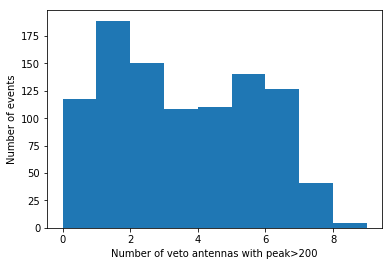

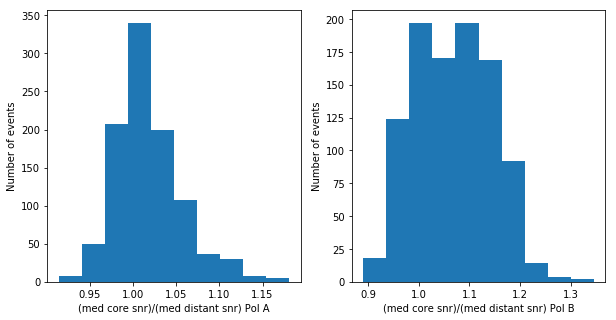

In [32]:
plt.figure()
plt.hist(n_veto_detections,9)
plt.xlabel('Number of veto antennas with peak>200')
plt.ylabel('Number of events')
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(core_vs_far_ratioA)
plt.xlabel('(med core snr)/(med distant snr) Pol A')
plt.ylabel('Number of events')

plt.subplot(122)
plt.hist(core_vs_far_ratioB)
plt.xlabel('(med core snr)/(med distant snr) Pol B')
plt.ylabel('Number of events')




In [37]:
#cut on events based on number of strong detections
minstrongdetections=50
detections_cut=np.logical_or(n_strong_detectionsA>=minstrongdetections,n_strong_detectionsB>=minstrongdetections)

#cut on events based on rms change and number of strong detections
min_rms_ratio=0.8
max_rms_ratio=1.2
rms_change_cutA=np.logical_and(rms_ratioA>min_rms_ratio,rms_ratioA<max_rms_ratio)
rms_change_cutB=np.logical_and(rms_ratioB>min_rms_ratio,rms_ratioB<max_rms_ratio)

#Iff a polarization has strong detections, it must satisfy the rms change cut
rms_change_cut_for_strong_detectionsA=np.logical_or(rms_change_cutA,n_strong_detectionsA<minstrongdetections)
rms_change_cut_for_strong_detectionsB=np.logical_or(rms_change_cutB,n_strong_detectionsB<minstrongdetections)

#At least one polarization must satisfy above
rms_change_cut=np.logical_and(rms_change_cut_for_strong_detectionsA,rms_change_cut_for_strong_detectionsB)

#cut on total number of veto antenna detections
maxveto=1  #throw away things detected by 2 or more veto antennas
veto_cut=n_veto_detections<=maxveto

#cut for events that are weaker for the distant antennas
minstrengthratio=1.22
distant_vs_core_cut=np.logical_or(core_vs_far_ratioA>minstrengthratio,core_vs_far_ratioB>minstrengthratio)

/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


Text(0,0.5,'median (rms after)/(rms before) for Pol B')

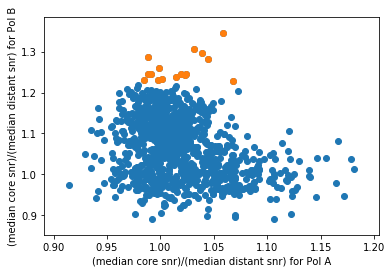

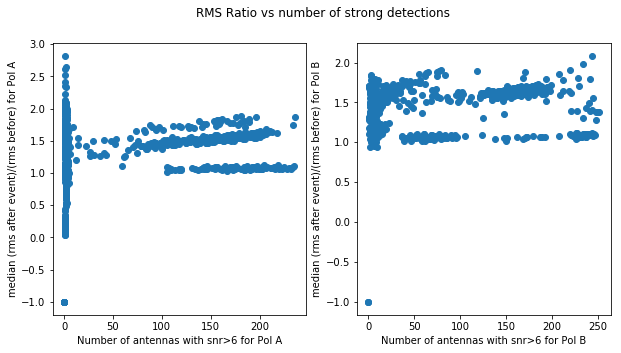

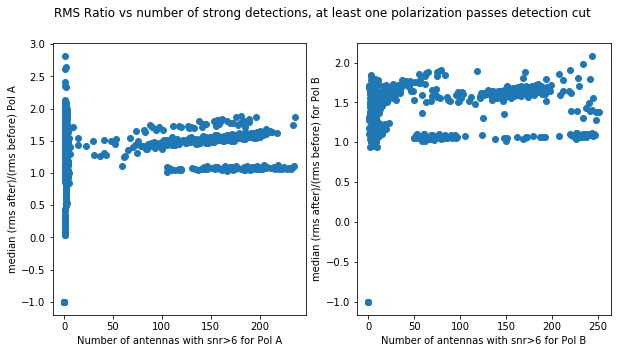

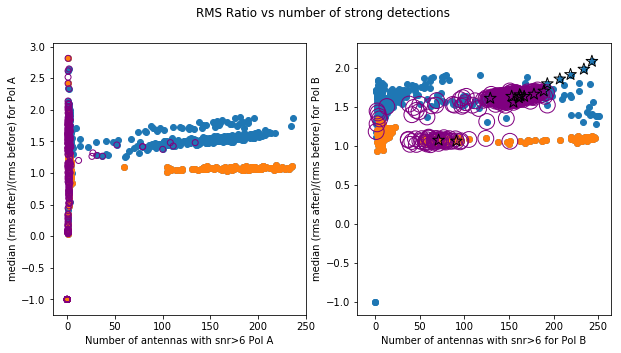

In [39]:
plt.figure()
plt.scatter(core_vs_far_ratioA,core_vs_far_ratioB)
plt.scatter(core_vs_far_ratioA[distant_vs_core_cut],core_vs_far_ratioB[distant_vs_core_cut])
plt.ylabel('(median core snr)/(median distant snr) for Pol B')
plt.xlabel('(median core snr)/(median distant snr) for Pol A')

plt.figure(figsize=(10,5))
plt.suptitle('RMS Ratio vs number of strong detections')
plt.subplot(121)
plt.scatter(n_strong_detectionsA,rms_ratioA)
plt.xlabel('Number of antennas with snr>6 for Pol A')
plt.ylabel('median (rms after event)/(rms before) for Pol A')
plt.subplot(122)
plt.scatter(n_strong_detectionsB,rms_ratioB)
plt.xlabel('Number of antennas with snr>6 for Pol B')
plt.ylabel('median (rms after event)/(rms before) for Pol B')



plt.figure(figsize=(10,5))
plt.suptitle('RMS Ratio vs number of strong detections, at least one polarization passes detection cut')
plt.subplot(121)
plt.xlabel('Number of antennas with snr>6 for Pol A')
plt.ylabel('median (rms after)/(rms before) Pol A')
plt.scatter(n_strong_detectionsA[detections_cut],rms_ratioA[detections_cut])
plt.subplot(122)
plt.scatter(n_strong_detectionsB[detections_cut],rms_ratioB[detections_cut])
plt.xlabel('Number of antennas with snr>6 for Pol B')
plt.ylabel('median (rms after)/(rms before) for Pol B')

plt.figure(figsize=(10,5))
plt.suptitle('RMS Ratio vs number of strong detections')
plt.subplot(121)
plt.scatter(n_strong_detectionsA[detections_cut],rms_ratioA[detections_cut])
plt.scatter(n_strong_detectionsA[np.logical_and(rms_change_cut,detections_cut)],rms_ratioA[np.logical_and(rms_change_cut,detections_cut)])
plt.scatter(n_strong_detectionsA[veto_cut],rms_ratioA[veto_cut],facecolor='None',edgecolor='purple')
plt.xlabel('Number of antennas with snr>6 Pol A')
plt.ylabel('median (rms after)/(rms before) for Pol A')

plt.subplot(122)
plt.scatter(n_strong_detectionsB[detections_cut],rms_ratioB[detections_cut])
plt.scatter(n_strong_detectionsB[np.logical_and(rms_change_cut,detections_cut)],rms_ratioB[np.logical_and(rms_change_cut,detections_cut)])
plt.scatter(n_strong_detectionsB[veto_cut],rms_ratioB[veto_cut],facecolor='None',edgecolor='purple',s=250)
plt.scatter(n_strong_detectionsB[distant_vs_core_cut],rms_ratioB[distant_vs_core_cut],facecolor='None',edgecolor='k',marker='*',s=150)
plt.xlabel('Number of antennas with snr>6 for Pol B')
plt.ylabel('median (rms after)/(rms before) for Pol B')

## Update plot_fit function

In [40]:
def plot_fit(x,y,toa_data,best_model_toas,residual,czoom_min,czoom_max,title):
    plt.figure(figsize=(15,10))
    plt.suptitle(title)
    plt.subplot(231)
    plt.axes='equal'
    plt.scatter(x,y,c=toa_data)
    plt.colorbar()
    plt.title('Observed relative TOAs')

    plt.subplot(232)
    plt.axes='equal'
    plt.scatter(x,y,c=best_model_toas)
    plt.colorbar()
    plt.title('Best fit model toas')


    plt.subplot(233)
    plt.axes='equal'
    plt.scatter(x,y,c=residual)
    plt.colorbar()
    plt.title('Residual')

    plt.subplot(234)
    plt.axes='equal'
    plt.scatter(x,y,c=toa_data)
    plt.colorbar()
    plt.xlim(-200,200)
    plt.ylim(-200,200)
    plt.clim(czoom_min,czoom_max)
    plt.title('Observed relative TOAs')

    plt.subplot(235)
    plt.axes='equal'
    plt.scatter(x,y,c=best_model_toas)
    plt.colorbar()
    plt.xlim(-200,200)
    plt.ylim(-200,200)
    plt.clim(czoom_min,czoom_max)
    plt.title('Best fit model toas')

    plt.subplot(236)
    plt.axes='equal'
    plt.scatter(x,y,c=residual)
    plt.colorbar()
    plt.xlim(-200,200)
    plt.ylim(-200,200)
    #plt.clim(czoom_min,czoom_max)
    plt.title('Residual')

## Examine interesting events



In [42]:
total_events_cut=np.logical_and(np.logical_and(np.logical_and(rms_change_cut,detections_cut),veto_cut),distant_vs_core_cut)
select_events=[complete_events[i] for i in range(len(complete_events)) if total_events_cut[i]]
print(len(select_events))


2


1 71 0.014084507042253521
Not enough polarization A detections to fit
Polarization B direction best theta, phi  [ 90.        347.4492681]
Covariance matrix [[ 6.93459140e+05 -2.50098424e+03]
 [-2.50098424e+03  3.18003278e+01]]


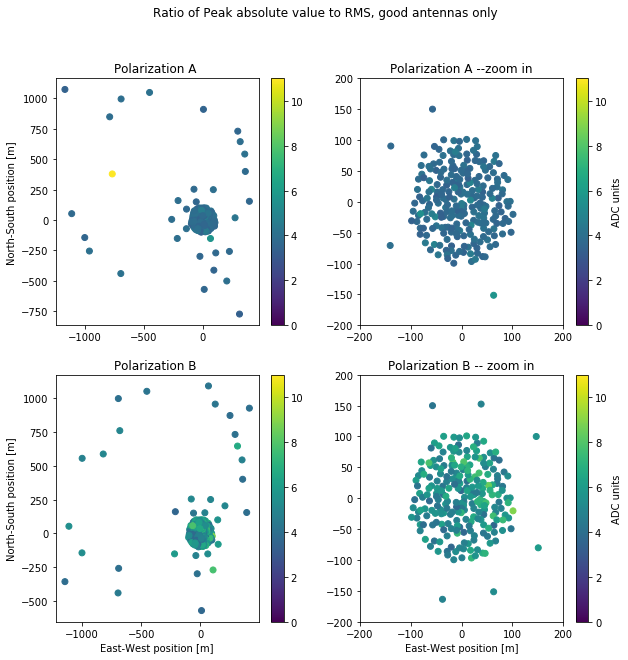

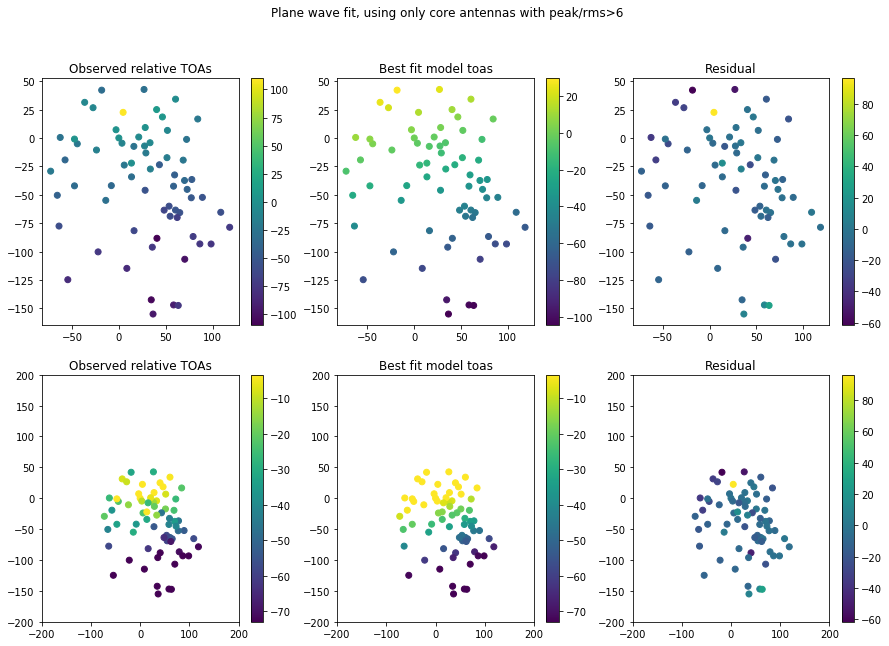

<Figure size 1440x288 with 0 Axes>

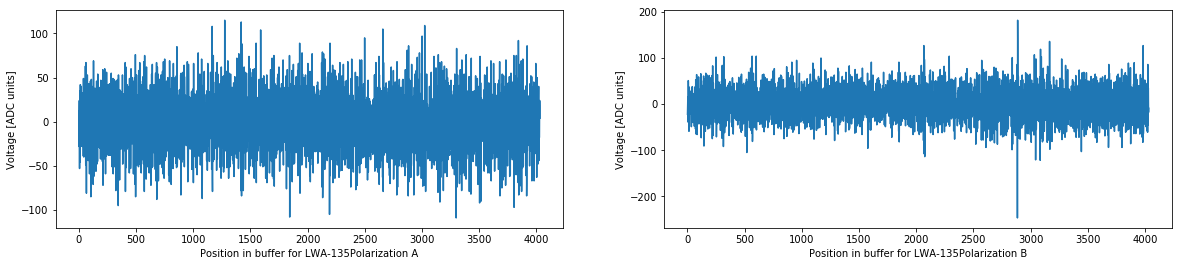

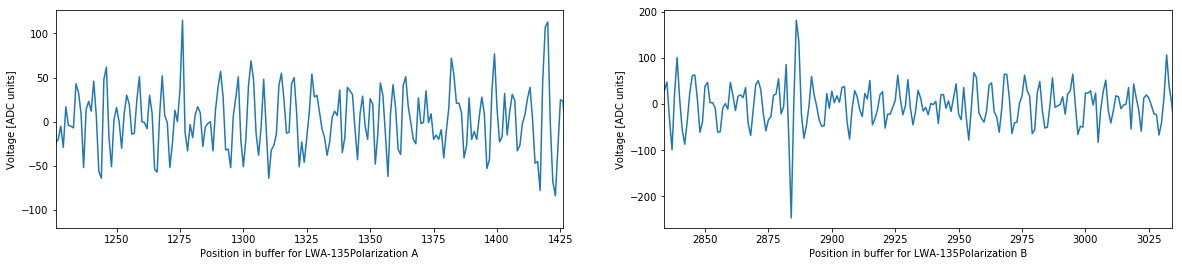

1 91 0.01098901098901099
Not enough polarization A detections to fit
Polarization B direction best theta, phi  [89.88360446 24.05183885]
Covariance matrix [[ 2.46222301e+07 -1.27257725e+05]
 [-1.27257725e+05  2.19755396e+03]]


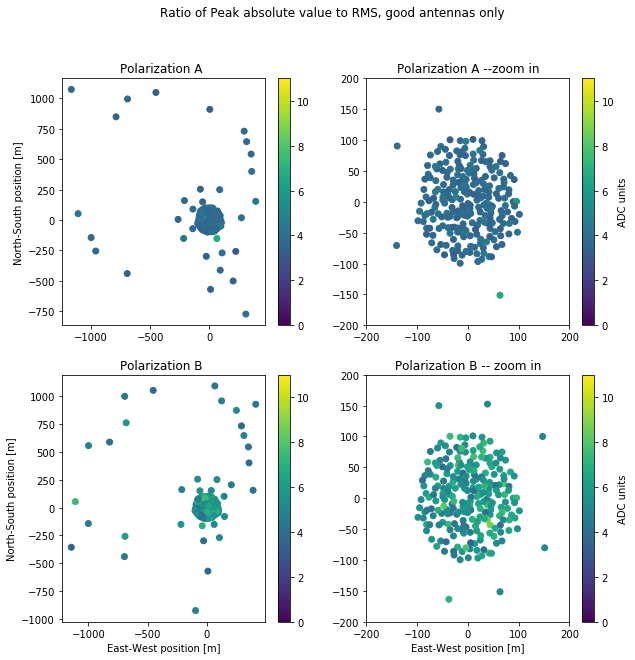

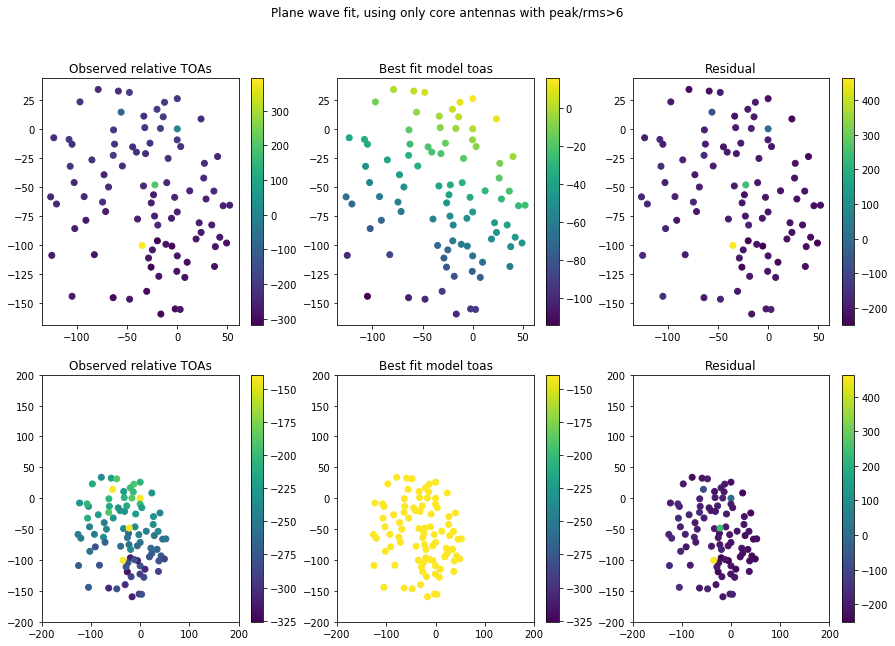

<Figure size 1440x288 with 0 Axes>

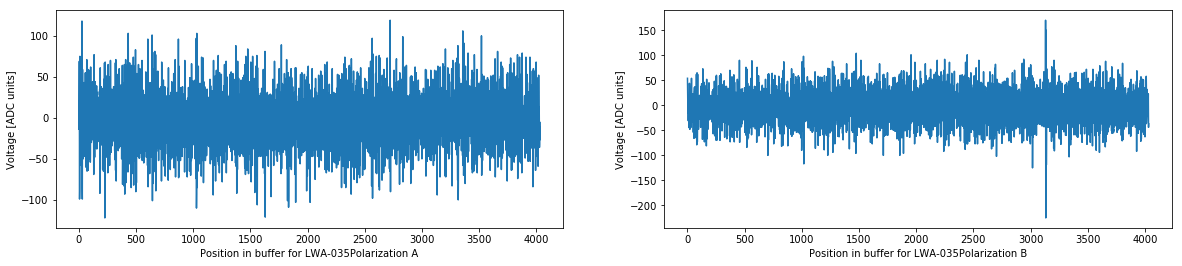

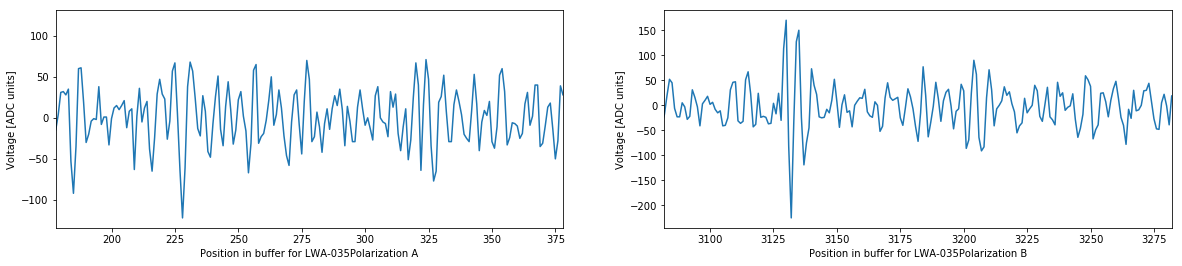

In [43]:
for event_indices in select_events:  
    event=[records[i] for i in event_indices]
    mergedrecords=mergepolarizations(event,arraymapdictionaries)

    rmsA=np.asarray([record['rmsA'] for record in mergedrecords])
    peakA=np.asarray([record['peakA'] for record in mergedrecords])
    index_peak_A=np.asarray([record['index_peak_A'] for record in mergedrecords])

    rmsB=np.asarray([record['rmsB'] for record in mergedrecords])
    peakB=np.asarray([record['peakB'] for record in mergedrecords])
    index_peak_B=np.asarray([record['index_peak_B'] for record in mergedrecords])
    peak_to_rmsA=peakA/rmsA
    peak_to_rmsB=peakB/rmsB

    xcoords=np.asarray([record['x'] for record in mergedrecords])
    ycoords=np.asarray([record['y'] for record in mergedrecords])
    zcoords=np.asarray([record['z'] for record in mergedrecords])
    timestamps=np.asarray([record['timestamp'] for record in mergedrecords])
    min_time=np.min(timestamps)

    t_rel_A=index_peak_A + timestamps - min_time
    t_rel_B=index_peak_B + timestamps - min_time

    #make antenna cut based on rms
    maximum_ok_rms=45
    minimum_ok_rms=25
    cutA = np.logical_and(rmsA >minimum_ok_rms, rmsA <maximum_ok_rms)
    cutB = np.logical_and(rmsB >minimum_ok_rms, rmsB <maximum_ok_rms)
    
    cmin=0
    cmax=11
    minsnr=6
    minstrongdetections=50
    plot_peak_to_rms_ratio(peak_to_rmsA,cutA,peak_to_rmsB,cutB,xcoords,ycoords,cmin,cmax)
    strongAdetections=np.sum((peak_to_rmsA[cutA])>minsnr)
    strongBdetections=np.sum((peak_to_rmsB[cutB])>minsnr)
    print(strongAdetections,strongBdetections,strongAdetections/strongBdetections)
    
    #make whole array toa plot too?
    
    #fit direction
    if strongAdetections>minstrongdetections:
        try:
            #direction fit polarization A
            #Make antenna-based cuts on rms, peak-to-rms ratio, and only use core
            #I'm still using the first antenna that passes the cuts as the reference antenna
            cut_snrA=np.logical_and(((peakA/rmsA) >minsnr), (cutA))
            cut_rms_snrA_core=np.logical_and(cut_snrA, (xcoords**2)+(ycoords**2)<(150**2))

            x=xcoords[cut_rms_snrA_core]-xcoords[cut_rms_snrA_core][0]
            y=ycoords[cut_rms_snrA_core]-ycoords[cut_rms_snrA_core][0]
            z=zcoords[cut_rms_snrA_core]-zcoords[cut_rms_snrA_core][0]

            t=t_rel_A[cut_rms_snrA_core]-t_rel_A[cut_rms_snrA_core][0]

            ant_coords=np.zeros((3,len(x)))
            ant_coords[0,:]=x
            ant_coords[1,:]=y
            ant_coords[2,:]=z

            popt, pcov = curve_fit(toa_plane, ant_coords,t,bounds=([0,0],[90,360]),jac=grad_toa_plane)

            print("Polarization A direction best theta, phi ",popt)
            print("Covariance matrix",pcov)
            theta_best=popt[0]
            phi_best=popt[1]

            #plot the results
            best_model_toas=toa_plane(ant_coords,theta_best,phi_best)
            residual=t-best_model_toas
            czoom_min=np.mean(t)-np.std(t)
            czoom_max=np.mean(t)+np.std(t)
            title='Plane wave fit, using only core antennas with peak/rms>'+str(minsnr)
            plot_fit(x,y,t,best_model_toas,residual,czoom_min,czoom_max,title)
        except RuntimeError:
            print("Fit failed with runtime error.")
    else:
        print("Not enough polarization A detections to fit")
    
    if strongBdetections>minstrongdetections:
        #direction fit polarization B
        #Make antenna-based cuts on rms, peak-to-rms ratio, and only use core
        #I'm still using the first antenna that passes the cuts as the reference antenna
        try:
            cut_snrB=np.logical_and(((peakB/rmsB) >minsnr), (cutB))
            cut_rms_snrB_core=np.logical_and(cut_snrB, (xcoords**2)+(ycoords**2)<(150**2))

            x=xcoords[cut_rms_snrB_core]-xcoords[cut_rms_snrB_core][0]
            y=ycoords[cut_rms_snrB_core]-ycoords[cut_rms_snrB_core][0]
            z=zcoords[cut_rms_snrB_core]-zcoords[cut_rms_snrB_core][0]

            t=t_rel_B[cut_rms_snrB_core]-t_rel_B[cut_rms_snrB_core][0]

            ant_coords=np.zeros((3,len(x)))
            ant_coords[0,:]=x
            ant_coords[1,:]=y
            ant_coords[2,:]=z

            popt, pcov = curve_fit(toa_plane, ant_coords,t,bounds=([0,0],[90,360]),jac=grad_toa_plane)

            print("Polarization B direction best theta, phi ",popt)
            print("Covariance matrix",pcov)
            theta_best=popt[0]
            phi_best=popt[1]

            #plot the results
            best_model_toas=toa_plane(ant_coords,theta_best,phi_best)
            residual=t-best_model_toas
            czoom_min=np.mean(t)-np.std(t)
            czoom_max=np.mean(t)+np.std(t)
            title='Plane wave fit, using only core antennas with peak/rms>'+str(minsnr)
            plot_fit(x,y,t,best_model_toas,residual,czoom_min,czoom_max,title)
        except RuntimeError:
            print("Fit failed with RuntimeError")
    
    else:
        print("Not enough polarization B detections to fit")
    
    
    #find the first example of an antenna with either A or B polarization above minsnr and plot its timeseries around the event
    plt.figure(figsize=(20,4))
    for r,record in enumerate(mergedrecords):
        if ((peak_to_rmsA[r]>minsnr) and cutA[r]) or ((peak_to_rmsB[r]>minsnr) and cutB[r]):
            plt.figure(figsize=(20,4))
            plt.subplot(121)
            plt.plot(record['polA_data'])
            plt.xlabel('Position in buffer for '+ record['antname'] +'Polarization A')
            plt.ylabel('Voltage [ADC units]')
            plt.subplot(122)
            plt.plot(record['polB_data'])
            plt.xlabel('Position in buffer for '+ record['antname'] +'Polarization B')
            plt.ylabel('Voltage [ADC units]')

            
            plt.figure(figsize=(20,4))
            plt.subplot(121)
            #note the different zoom for each pol
            plt.plot(record['polA_data'])
            plt.xlim(record['index_peak_A']-50,record['index_peak_A']+150)
            plt.xlabel('Position in buffer for '+ record['antname'] +'Polarization A')
            plt.ylabel('Voltage [ADC units]')
            plt.subplot(122)
            plt.plot(record['polB_data']) 
            plt.xlim(record['index_peak_B']-50,record['index_peak_B']+150)
            plt.xlabel('Position in buffer for '+ record['antname'] +'Polarization B')
            plt.ylabel('Voltage [ADC units]')
            plt.show()
            break

## Save indices for those two events

In [47]:
np.save('best-2-events-out-of-1st-1000',np.asarray(select_events))

Loading is taking too long for just two events. Something is wrong with the code below.

In [49]:
##loading is taking too long for so few events!! 
saved_events_indices=np.load('best-2-events-out-of-1st-1000.npy')
fname='/data0/cosmic-ray-data/2023May3/overnight1683180640.2699194.dat'

#load data for saved selected records
records2=[]
for event in saved_events_indices:
    for r in event:
        r=parsefile(fname, start_ind=r, end_ind = r+1)
        records2.append(r)
    

#make a list of events
events2=distinguishevents(records2,200)
complete_events_count=0
incomplete_events_count=0
total=len(events)
for e in events:
    if len(e)==704:
        complete_events_count+=1
    else:
        incomplete_events_count+=1
print("Out of ",total," events, there are ",complete_events_count," have exactly 704 records assigned and ", incomplete_events_count, ' events have the wrong number of records.')
print('End time ',time.time())

KeyboardInterrupt: 